# Task 1 Implement and Train a VAE##

Implement a VAE using (de)convolutional neural networks with pytorch.  
1 Construct your model so that its latent space Z is K-dimensional, with K > 1, and such that  
p(X | z) is (multivariate) Gaussian with independent components, i.e. such that  

p(X | z) =  
∏<sub>d=1</sub><sup>D</sup> p(X<sub>d</sub> | z) =  
∏<sub>d=1</sub><sup>D</sup> 𝒩(X<sub>d</sub> | μ<sub>d</sub>(z), σ²<sub>d</sub>(z)) for all z ∈ Z,  

where D ∈ ℕ is the number of features in the data, where  
X = (X₁, ..., X_D), and where  
μ(z) = (μ₁(z), ..., μ_D(z)) and  
σ²(z) = (σ²₁(z), ..., σ²_D(z))  
are the outputs of the decoder network of the VAE, when evaluated in z.  

Make sure your code can load and use the MNIST (digits) dataset; verify that it contains 60,000 training images and 10,000 testing images. Normalize the pixel values so they are represented as numerical values in the range [0, 1] (by dividing by 255). Split the training data such that you can use the first 50,000 images for training, and the last 10,000 images for validation.

Implement a routine to train your model on the 50,000 training images by maximising the (estimated) ELBO, using pytorch’s autodiff functionality and built-in optimisers (e.g. Adam). Use a batch size of your choice. Use your code to answer the following questions:

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import math

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)
        # Decoder
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(16, 2, 4, stride=2, padding=1)   # 14x14 -> 28x28

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc(z))
        h = h.view(-1, 32, 7, 7)
        h = F.relu(self.deconv1(h))
        h = self.deconv2(h)
        mu, logvar = h[:, :1, :, :], h[:, 1:, :, :]  # Split output into mu and logvar
        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_mu, recon_logvar = self.decode(z)
        return recon_mu, recon_logvar, mu, logvar

# ===========================
# Gaussian log-likelihood reconstruction loss
# ===========================

def loss_function(recon_mu, recon_logvar, x, mu, logvar):
    # Gaussian likelihood log p(x|z)
    recon_var = torch.exp(recon_logvar)
    log_px_z = -0.5 * (torch.log(2 * torch.pi * recon_var) + ((x - recon_mu)**2) / recon_var)
    log_px_z = log_px_z.sum()  # Sum over all pixels and batch

    # KL divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return -log_px_z + KLD, -log_px_z, KLD

# Data loading and splitting
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(mnist, [50000, 10000])
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
dl_train = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(val_ds, batch_size=batch_size)
dl_test = DataLoader(test_ds, batch_size=batch_size)

# Initialize model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.1e-3)



In [96]:
num_epochs = 90
train_elbo = []
val_elbo = []
train_KLD = []
val_KLD = []
train_BCE = []
val_BCE = []

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        recon_mu, recon_logvar, mu, logvar = model(x)
        loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()
    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo.append(avg_train_elbo)
    train_BCE.append(total_rec / len(train_ds))
    train_KLD.append(total_kld / len(train_ds))

    model.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            recon_mu, recon_logvar, mu, logvar = model(x)
            loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()
    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo.append(avg_val_elbo)
    val_BCE.append(total_val_rec / len(val_ds))
    val_KLD.append(total_val_kld / len(val_ds))
    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_BCE) >= 15:
        average_last_10_val_BCE = sum(val_BCE[-10:]) / 10
        average_last_15_val_BCE = sum(val_BCE[-15:]) / 15
        if average_last_15_val_BCE - average_last_10_val_BCE < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation BCE.")
            #break

# Plotting ELBO curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_elbo, label='Train ELBO')
plt.plot(range(1, num_epochs+1), val_elbo, label='Val ELBO')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()
plt.title('ELBO')

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_BCE, label='Train log p(x|z)')
plt.plot(range(1, num_epochs+1), val_BCE, label='Val log p(x|z)')
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.legend()
plt.title('Reconstruction Term')

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_KLD, label='Train KLD')
plt.plot(range(1, num_epochs+1), val_KLD, label='Val KLD')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title('KL Divergence')

plt.tight_layout()
plt.show()

Epoch 01, Train ELBO: 2535.8498, Val ELBO: 2785.2718
Epoch 02, Train ELBO: 2545.6874, Val ELBO: 859.8908
Epoch 03, Train ELBO: 2289.8573, Val ELBO: 2531.1019
Epoch 04, Train ELBO: 2605.0903, Val ELBO: 3019.4005
Epoch 05, Train ELBO: 2589.3816, Val ELBO: 2774.9671
Epoch 06, Train ELBO: 2644.3723, Val ELBO: 2496.5114
Epoch 07, Train ELBO: 2619.9022, Val ELBO: 2867.4645
Epoch 08, Train ELBO: 2711.6638, Val ELBO: 2946.0663
Epoch 09, Train ELBO: 2710.8643, Val ELBO: 2831.5788
Epoch 10, Train ELBO: 2714.5927, Val ELBO: 2868.0487
Epoch 11, Train ELBO: 2727.9558, Val ELBO: 2930.2519


: 

In [95]:
#save the model to file
torch.save(model.state_dict(), 'conv_vae_mnist.pth')

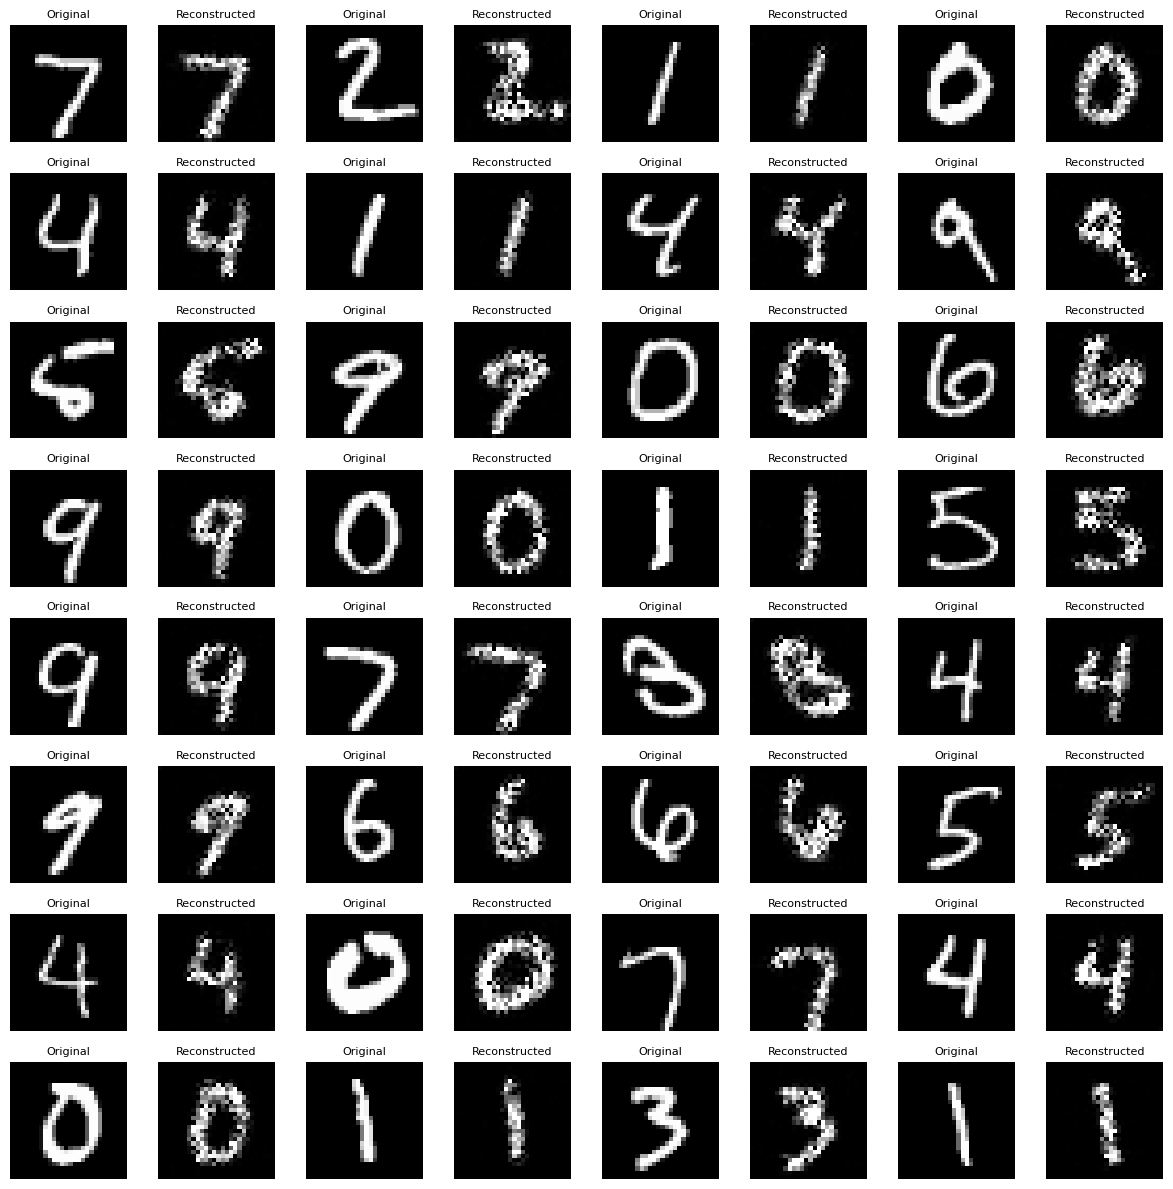

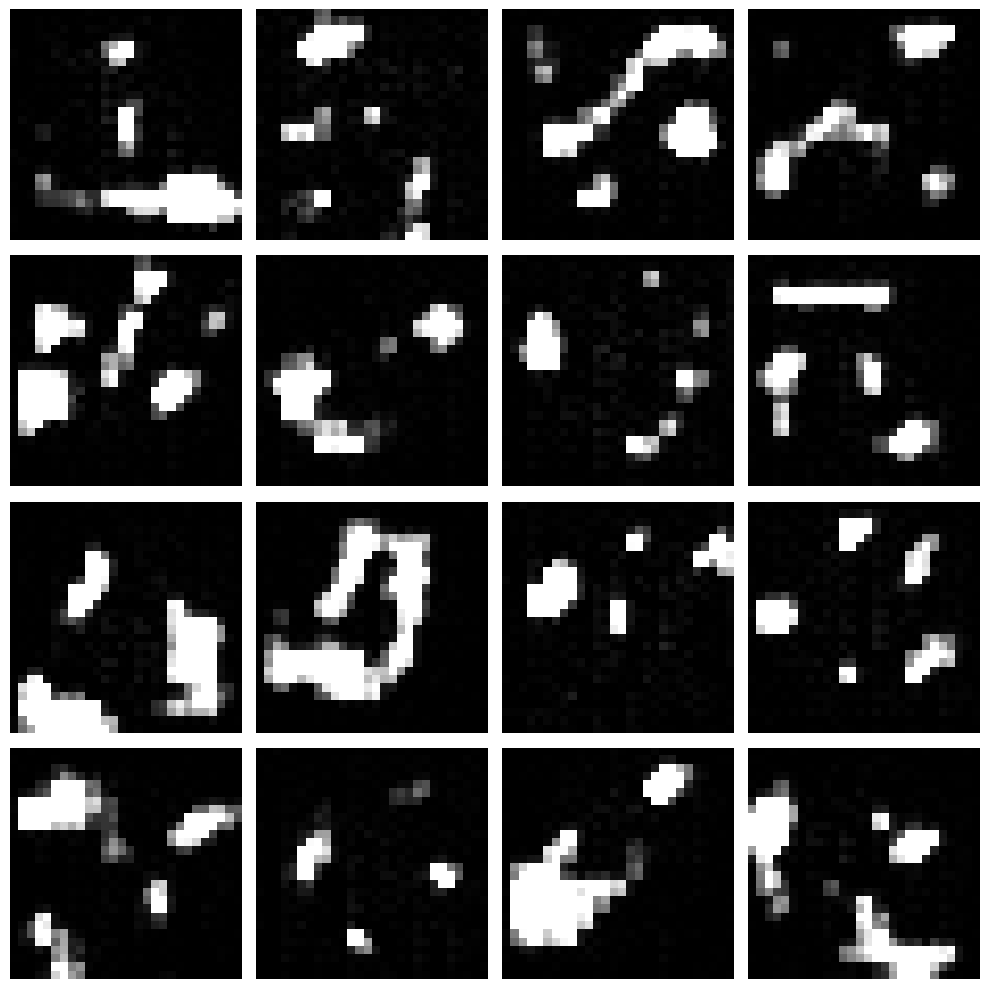

In [ ]:
#load the model from file
model = ConvVAE(latent_dim=20).to(device)
model.load_state_dict(torch.load('conv_vae_mnist.pth'))

# Reconstructions
model.eval()
with torch.no_grad():
    # Get first 32 test images
    test_batch = next(iter(dl_test))
    test_batch = test_batch[0][:32].to(device)  # Take first 32 images and move to device
    
    # Get reconstructions
    mu, logvar = model.encode(test_batch)
    z = model.reparameterize(mu, logvar)
    recon_mu, recon_logvar = model.decode(z)
    reconstructions = recon_mu + torch.exp(0.5*recon_logvar) * torch.randn_like(recon_mu)
    # Clip reconstructions to [0, 1] range
    reconstructions = torch.clamp(reconstructions, 0, 1)
    
    # Create grid: [orig1, recon1, orig2, recon2, ...]
    grid_images = []
    for i in range(32):
        grid_images.append(test_batch[i].cpu())
        grid_images.append(reconstructions[i].cpu())
    
    # Plot 8×8 grid
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid_images[i].squeeze().cpu().detach().numpy(), cmap='gray')
        ax.axis('off')
        # Label columns
        if i % 2 == 0:
            ax.set_title("Original", fontsize=8)
        else:
            ax.set_title("Reconstructed", fontsize=8)
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=150)
    plt.show()



# Sample from prior
z = torch.randn(16, 20).to(device)  # 64 samples
recon_mu, recon_logvar = model.decode(z)
generated = recon_mu + torch.exp(0.5*recon_logvar) * torch.randn_like(recon_mu)
# Clip generated images to [0, 1] range
generated = torch.clamp(generated, 0, 1)

# Plot 8×8 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].cpu().detach().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i+1}", fontsize=8)
plt.tight_layout()
plt.savefig('generations.png', dpi=150)
plt.show()
